# Data Science Summer Intern assignment 2021
A crucial part of any business, especially for firms like Wolt, is its ability to predict demand. In this assignment, I will try to predict the orders in a certain hour from the dataset, which was provided.  

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels
import statsmodels.api as sm

## Data
Lest's, first import the dataset and take a look at the columns

In [37]:
url_orders = "https://raw.githubusercontent.com/woltapp/data-science-summer-intern-2021/main/orders_autumn_2020.csv"
orders = pd.read_csv(url_orders)
orders.head(3).transpose()

,0,1,2
TIMESTAMP,2020-08-01 06:07:00.000,2020-08-01 06:17:00.000,2020-08-01 06:54:00.000
ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,-19,-7,-17
ITEM_COUNT,1,8,4
USER_LAT,60.158,60.163,60.161
USER_LONG,24.946,24.927,24.937
VENUE_LAT,60.16,60.153,60.162
VENUE_LONG,24.946,24.91,24.939
ESTIMATED_DELIVERY_MINUTES,29,39,23
ACTUAL_DELIVERY_MINUTES,10,32,6
CLOUD_COVERAGE,0,0,0


Adding columns to indicate the hour, date, weekday and a index column.

In [38]:
orders["TIMESTAMP"] = pd.to_datetime(orders["TIMESTAMP"])
orders["N"] = orders.index 
orders["HOUR"] = orders["TIMESTAMP"].dt.hour
orders["DATE"] = orders["TIMESTAMP"].dt.date
orders["DATE_HOUR"] = orders["TIMESTAMP"].dt.floor("H")
orders["WEEKDAY_INDEX"] = orders["TIMESTAMP"].dt.weekday
orders["WEEKDAY"] = orders["TIMESTAMP"].dt.day_name().str[:3]
orders.head(3)[["TIMESTAMP", "N", "HOUR", "DATE", "DATE_HOUR", "WEEKDAY_INDEX", "WEEKDAY"]].transpose()

,0,1,2
TIMESTAMP,2020-08-01 06:07:00,2020-08-01 06:17:00,2020-08-01 06:54:00
N,0,1,2
HOUR,6,6,6
DATE,2020-08-01,2020-08-01,2020-08-01
DATE_HOUR,2020-08-01 06:00:00,2020-08-01 06:00:00,2020-08-01 06:00:00
WEEKDAY_INDEX,5,5,5
WEEKDAY,Sat,Sat,Sat


## Exploration
Lets then take a look at how the orders behave as a process fluctuating in time. The first interesting question is how much do the orders differ on a daily basis, and is there any seasonality in the fluctuation.  
As we can see from the figure below, there is relatively high variation in the daily orders and there seems to be weekly seasonality in the data. There seems to be a small upward trend but, it's minute compared to the overall fluctuation.

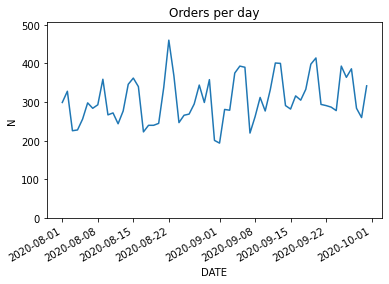

In [39]:
orders_per_date = orders.groupby("DATE").agg({"N": "count"}).sort_values("DATE")
orders_per_date.reset_index(inplace=True)
fig = plt.figure()
ax = sns.lineplot(data=orders_per_date, x="DATE", y="N")
ax.set_title("Orders per day")
ax.set(ylim=(0, orders_per_date["N"].max() * 1.1))
fig.autofmt_xdate()

Next let's investigate the weekly seasonality in the data. As can be seen from the barplot below, there are much more orders in the weekends compared to business days.

Text(0.5, 1.0, 'Orders per weekday in 1.8.2020-30.9.2020')

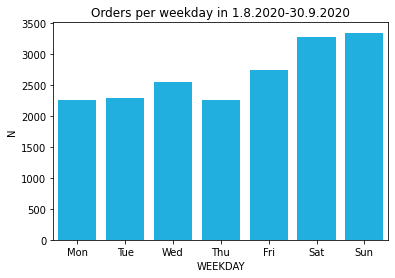

In [40]:
orders_per_weekday = orders.groupby("WEEKDAY_INDEX").agg({"N":"count", "WEEKDAY":"first"})
ax = sns.barplot(data=orders_per_weekday, x="WEEKDAY", y="N", color = "deepskyblue")
ax.set_title("Orders per weekday in 1.8.2020-30.9.2020")

It would also make sense that there is a huge variation caused by the hour of the day. Probably not many people are ordering 5 am in the morning. As can be seen below this is the case. However surprisingly many are ordering breakfast.

Text(0.5, 1.0, 'Distributin of orders in a day in 1.8.2020-30.9.2020')

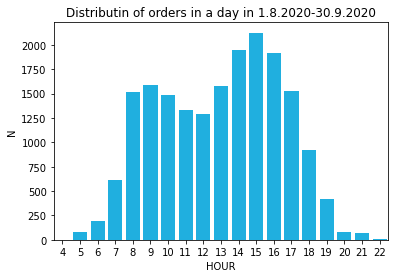

In [41]:
orders_daily_distribution = orders.groupby("HOUR").agg({"N":"count"})
orders_daily_distribution["HOUR"] = orders_daily_distribution.index
ax = sns.barplot(data=orders_daily_distribution, x="HOUR", y="N", color = "deepskyblue")
ax.set_title("Distributin of orders in a day in 1.8.2020-30.9.2020")

Let's now take a look at how much this hourly variation varies between weekdays.
There is a significant amount of variation

Text(0.5, 1.0, 'Distributin of orders in a day per date in 1.8.2020-30.9.2020')

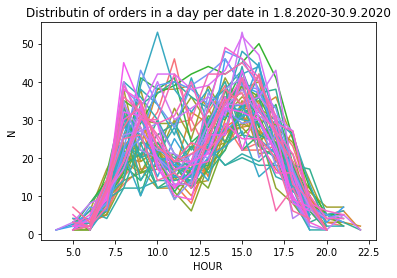

In [42]:
orders_daily_distribution_by_date = orders.groupby(["DATE","HOUR"]).agg({"N":"count"})
orders_daily_distribution_by_date.reset_index(inplace=True)
ax = sns.lineplot(data=orders_daily_distribution_by_date, x="HOUR", y="N", hue = "DATE")
ax.get_legend().remove()
ax.set_title("Distributin of orders in a day per date in 1.8.2020-30.9.2020")

One clear suspicion for this variation impact of weekday. It’s quite likely that people are ordering more at lunchtime on weekends. As can be seen from the figure below this is the case

Text(0.5, 1.0, 'Distributin of orders in a day per weekday in 1.8.2020-30.9.2020')

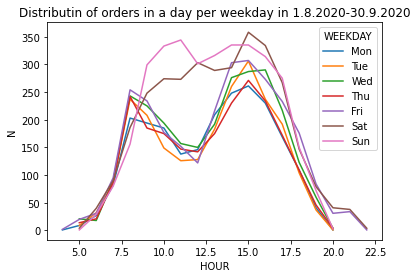

In [43]:
orders_daily_distribution_by_weekday = orders.groupby(["WEEKDAY_INDEX","HOUR"]).agg({"N":"count", "WEEKDAY":"first"})
orders_daily_distribution_by_weekday
ax = sns.lineplot(data=orders_daily_distribution_by_weekday, x="HOUR", y="N", hue="WEEKDAY")
ax.set_title("Distributin of orders in a day per weekday in 1.8.2020-30.9.2020")

## Modelling
As the amount of datapoint is rather small 940,I went with something rather simple, not to overfit the model. The first approach was to do a **multivariate regression**, where the target variable is hourly orders. Also it’s easy to aggregate the hourly orders to get daily orders.
The hourly prediction has more value compared to something smaller like orders in one minute.  
Let’s aggregate the data accordingly.


In [44]:
orders_per_hour = orders.groupby("DATE_HOUR").agg({"N":"count",'HOUR':"first",
                                                   'WEEKDAY_INDEX':"first",
                                                   'WEEKDAY':"first",'CLOUD_COVERAGE':"mean",
                                                   'TEMPERATURE':"mean", 'WIND_SPEED':"mean",
                                                   'PRECIPITATION':"mean"}) 
orders_per_hour.fillna(orders_per_hour.mean(), inplace=True)


### Evaluation metrics
Common evaluation term for linear regression is the adjusted r squared, and this is what I used to evaluate the effect of adding features. In addition, to evaluate the predictive capability of the model I used the mean difference of observed and predicted orders because it’s likely that in a business scenario the loss of predicting the orders incorrectly is linear. 

Let’s create two functions, one that adds dummy variables for the hour column and one that splits the data to training and test sets, builds the model and calculates the evaluation metrics.

In [45]:
def add_dummies(df_in):
    df = df_in.copy()
    df["WEEKEND"] =  df["WEEKDAY_INDEX"].isin([5,6])
    for i in range(0,24):
        df["WORKDAYS_HOUR_" + str(i)] = ((df["HOUR"] == i )& (~df["WEEKEND"])).astype(int)
    for i in range(0,24):
        df["WEEKEND_HOUR_" + str(i)] = ((df["HOUR"] == i ) & (df["WEEKEND"])).astype(int)
    return df

def create_model(df_in):
    df = df_in.copy()
    X = df.drop(columns="N")
    y = df[["N"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model = sm.OLS(y_train, X_train).fit()
    r2_adj = model.rsquared_adj
    mean_diff = (model.predict(X_test) - y_test["N"]).abs().mean()
    return (r2_adj, mean_diff)
    

### Features
#### First iteration
First, let’s try modelling using as the features only the hour of the day divided into workdays and weekend as there was a significant difference in the hourly distribution between the workdays and weekend.

In [46]:
df1 = orders_per_hour
df1 = add_dummies(df1)
df1.drop(columns=["HOUR", "WEEKDAY_INDEX", "WEEKDAY", "CLOUD_COVERAGE", 
          "TEMPERATURE", "WIND_SPEED", "PRECIPITATION", "WEEKEND"], inplace=True)

The model fits the data rather well and the prediction capability is surprisingly good.

In [47]:
m1_adjusted_r2, m1_mean_difference = create_model(df1)
print(f"""The adjusted r squared of model i is : {m1_adjusted_r2:.2f} 
\nThe mean difference between observed and predicted orders is: {m1_mean_difference:.2f}""")

The adjusted r squared of model i is : 0.79 

The mean difference between observed and predicted orders is: 3.89


#### Second iteration
As the hourly orders is a time series,  it probably has some autoregressive behaviour.
Let’s investigate this by plotting autocorrelation functions:
As can be seen below the daily orders is seasonal so we can not draw any conclusions other than that, but it seems that there is some correlation between orders this day and previous day.

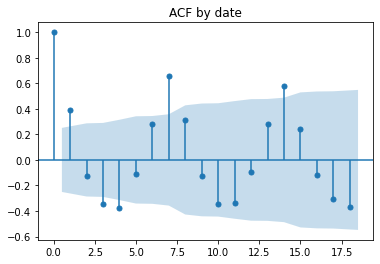

In [48]:
fig1 = statsmodels.graphics.tsaplots.plot_acf(orders_per_date["N"],
                                              title= "ACF by date")

However, this correlation diminishes when we remove the weekly seasonality.

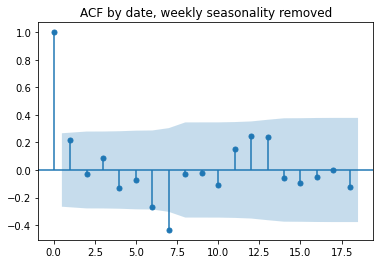

In [49]:
fig2 = statsmodels.graphics.tsaplots.plot_acf(orders_per_date["N"].diff(7).dropna(),
                                              title="ACF by date, weekly seasonality removed")

Let’s now plot the autocorrelation function of hourly orders. As can be seen, there is a correlation between an hour and both the previous hour and the hour before that

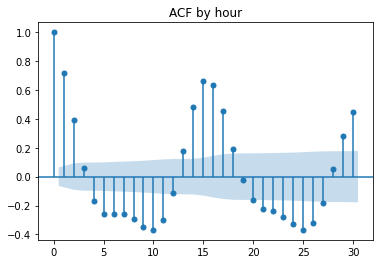

In [50]:
fig3 = statsmodels.graphics.tsaplots.plot_acf(orders_per_hour["N"],
                                              title="ACF by hour")

With this knowledge let’s add the orders one and two hours ago as features to the model.  In addition, let’s add the difference of these features also to the model, as it’s possible that if the orders in an hour are growing they might continue growing.

In [51]:
df2 = orders_per_hour.copy()
df2 = add_dummies(df2)
df2["N_lag_1"] = df2["N"].shift(1).fillna(0)
df2["N_lag_2"] = df2["N"].shift(2).fillna(0)
df2["N_difference_lag1_lag2"] = df2["N"].shift(1).fillna(0) - df2["N"].shift(2).fillna(0)
df2.drop(columns=["HOUR", "WEEKDAY_INDEX", "WEEKDAY", "CLOUD_COVERAGE", 
          "TEMPERATURE", "WIND_SPEED", "PRECIPITATION", "WEEKEND"], inplace=True)

The addition of these features did not significantly affect the r squared but they improved the predictive cabability.

In [52]:
m2_adjusted_r2, m2_mean_difference = create_model(df2)
print(f"""The adjusted r squared of model i is : {m2_adjusted_r2:.2f}
\nThe mean difference between observed and predicted orders is: {m2_mean_difference:.2f}""")

The adjusted r squared of model i is : 0.81

The mean difference between observed and predicted orders is: 3.90


#### Third iteration
Let’s explore if weather forecast could be used to predict the hourly orders. As can be seen, they did not have an impact on the predictive capability of the model.

In [53]:
df3 = orders_per_hour.copy()
df3 = add_dummies(df3)
df3["N_lag_1"] = df3["N"].shift(1).fillna(0)
df3["N_lag_2"] = df3["N"].shift(2).fillna(0)
df3["N_difference_lag1_lag2"] = df3["N"].shift(1).fillna(0) - df3["N"].shift(2).fillna(0)
df3.drop(columns=["HOUR", "WEEKDAY_INDEX", "WEEKDAY", "WEEKEND"], inplace=True)

In [54]:
m3_adjusted_r2, m3_mean_difference = create_model(df3)
print(f"""The adjusted r squared of model i is : {m3_adjusted_r2:.2f}
\nThe mean difference between observed and predicted orders is: {m3_mean_difference:.2f}""")


The adjusted r squared of model i is : 0.82

The mean difference between observed and predicted orders is: 3.90


#### Fourth iteration
Let’s finally try a more complex ML model gradient boosting regressor and play around with the settings. The predicting capability was not as good as in the OLS model.

In [55]:
df  = df3.copy()
X = df.drop(columns="N")
y = df[["N"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train.values.ravel())
m3_mean_difference = (reg.predict(X_test) - y_test["N"]).abs().mean()
print(f"The mean difference between observed and predicted orders is: {m3_mean_difference:.2f}")

The mean difference between observed and predicted orders is: 4.70


In [56]:
df  = df3.copy()
X = df.drop(columns="N")
y = df[["N"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
reg = GradientBoostingRegressor(loss="huber",random_state=0)
reg.fit(X_train, y_train.values.ravel())
m3_mean_difference = (reg.predict(X_test) - y_test["N"]).abs().mean()
print(f"The mean difference between observed and predicted orders is: {m3_mean_difference:.2f}")

The mean difference between observed and predicted orders is: 4.78


In [57]:
df  = df3.copy()
X = df.drop(columns="N")
y = df[["N"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
reg = GradientBoostingRegressor(n_estimators = 500, learning_rate = 0.1,random_state=0)
reg.fit(X_train, y_train.values.ravel())
m3_mean_difference = (reg.predict(X_test) - y_test["N"]).abs().mean()
print(f"The mean difference between observed and predicted orders is: {m3_mean_difference:.2f}")

The mean difference between observed and predicted orders is: 4.34


## Evaluation and further development
The OLS model was clearly better. Its main strength is its simplicity. It is fast to run on a larger scale and we can see the impact of different features on the predicted demand. However, the simplicity leaves feature engineering the only option to improve the model, which requires a lot of labour, compared to the model with feature learning capability.

There predictive capability of the model was sufficient in my mind as 91% of the predictions were +- 20% of the actual demand. 
Still, there is much to improve as it, not 100%. 
First of all, I would add public holidays as features.
Then, I would add Wolts internal data of marketing efforts.
To achieve the best results for Wolts entire market, I would build a hierarchical Bayesian model to account the difference between locations. 


## My background and Wolt

My background is in industrial engineering and management, so my past projects are highly business-related. I’m minoring in data science. I have been a data-analyst trainee at Nokia.

### My skills
#### R
Quickly clean up dirty data. In my experience, this is where we spend most of our time. Dplyr library is the secret. Unfortunately, I have not found a library that great for Python.
I have used Caret for ML. I can also do magnificent graphs with GGplot.
#### Python
Basic ML algorithms with Scikit-learn. I was granted GPT-3 early access early fall so I have been playing with the API.

#### Power BI and Excel
Power queries, DAX and VBA. Tools that I have been using most at work.

#### Stan
Done Bayesian Data Analysis -course, where I learned to build Bayesian ML models

### The most memorable projects

Last summer at Nokia I built two reporting tools with Python and Power BI. The models fetched highly business-critical data from several databases. The purpose of these tools was to track the performance of product groups and customer segments. I used linear regression to analyse the value of products, as the products are sold in bundled packages to customers.

Fall 2020 I participated in BSC Gammathon where our task was to predict the customers who would churn from a benefit program, and target marketing campaigns accordingly. Our solution consisted of a logistic regression model with heavy feature engineering. 

On the course Bayesian data analysis we built a hierarchical regression model to predict the exam results of a course that I used to be the head assistant of. The model is used for detecting cheating.

### Projects that I would love to be part of at Wolt

#### Reporting tools for management
Creating automatic reports is something that I am great at and enjoy doing, and here I can also utilize my major.

#### Predict people that will churn
As mentioned earlier, this is a matter I have spent a significant amount of time thinking about. It is a curiosity of mine - I also believe it to be the critical aspect of the success of a business.

#### GPT-3 or other NLP algorithms
This is probably already done at Wolt, but it would be useful to categorise new restaurants based on their menus and descriptions.

#### The impact of seasonality and marketing on demand 

A year ago we did a project for Relex, and their main competitive advantage is their ability to detect spikes in demand that are influenced by marketing and seasonality. This subject really interests me.
